# Hyperparameters

Consider the Booth test function (below). This function varies differently in different directions, and these directions are somewhat skewed with respect to the inputs. Our agent will automatically fit the right hyperparameters to account for this.

/home/jmoylan1/miniconda3/envs/test_tiled_new/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Text(0, 0.5, 'x2')

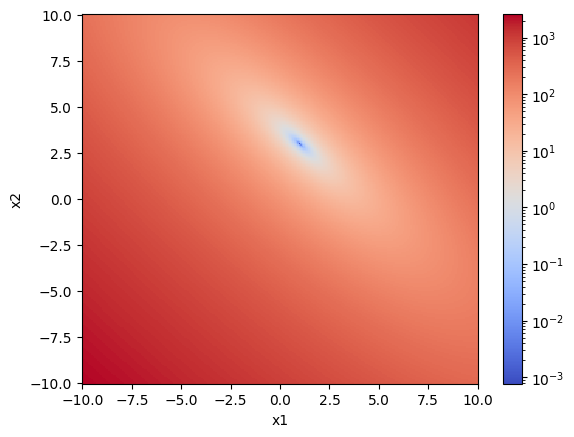

In [1]:
import matplotlib as mpl
import numpy as np
from matplotlib import pyplot as plt

from blop.utils import functions

x1 = x2 = np.linspace(-10, 10, 256)
X1, X2 = np.meshgrid(x1, x2)

F = functions.booth(X1, X2)

plt.pcolormesh(x1, x2, F, norm=mpl.colors.LogNorm(), shading="auto")
plt.colorbar()
plt.xlabel("x1")
plt.ylabel("x2")

The optimization goes faster if our model understands how the function changes as we change the inputs in different ways. The way it picks up on this is by starting from a general model that could describe a lot of functions, and making it specific to this one by choosing the right hyperparameters. Our Bayesian agent is very good at this, and only needs a few samples to figure out what the function looks like:

In [2]:
def digestion(df):
    for index, entry in df.iterrows():
        df.loc[index, "booth"] = functions.booth(entry.x1, entry.x2)

    return df

In [ ]:
import datetime
from bluesky.run_engine import RunEngine
from bluesky.callbacks import best_effort
from bluesky.callbacks.tiled_writer import TiledWriter
from tiled.client import from_uri
from ophyd.utils import make_dir_tree# Constants
from tiled.server import SimpleTiledServer
from tiled.client import from_uri


SERVER_HOST_LOCATION = "http://localhost:8000"
DEFAULT_DB_TYPE = "local"
DEFAULT_ROOT_DIR = "/tmp/sirepo-bluesky-data"# Initialize Tiled client

tiled_server = SimpleTiledServer()
tiled_client = from_uri(tiled_server.uri)
tiled_writer = TiledWriter(tiled_client)# Function to set up Bluesky environment

def setup_re_env(db_type="default", root_dir="/default/path"):
    RE = RunEngine({})
    bec = best_effort.BestEffortCallback()
    RE.subscribe(bec)
    RE.subscribe(tiled_writer)
    _ = make_dir_tree(datetime.datetime.now().year, base_path=root_dir)
    return dict(RE=RE, db=tiled_client, bec=bec)# Initialize the environment
env = setup_re_env(db_type="temp", root_dir=DEFAULT_ROOT_DIR)
globals().update(env)

2025-04-02 09:41:27.886 INFO: Subprocess stdout: 
2025-04-02 09:41:27.887 INFO: Subprocess stderr: Database sqlite+aiosqlite:////tmp/tmpgzs0qed1/catalog.db is new. Creating tables.
Database initialized.

Tiled version 0.1.0b21.dev13+g2ac3a565
2025-04-02 09:41:28.173 INFO: Tiled version 0.1.0b21.dev13+g2ac3a565
2025-04-02 09:41:28.176 INFO: Context impl SQLiteImpl.
2025-04-02 09:41:28.176 INFO: Will assume non-transactional DDL.
2025-04-02 09:41:28.281 INFO: HTTP Request: GET http://127.0.0.1:44975/api/v1?api_key=f4bef62731f6ad31 "HTTP/1.1 307 Temporary Redirect"
2025-04-02 09:41:28.287 INFO: HTTP Request: GET http://127.0.0.1:44975/api/v1/ "HTTP/1.1 200 OK"
2025-04-02 09:41:28.309 INFO: HTTP Request: GET http://127.0.0.1:44975/api/v1/metadata/ "HTTP/1.1 200 OK"


2025-04-02 09:41:29.008 INFO: HTTP Request: GET http://127.0.0.1:44975/api/v1/table/partition/ca004c34-b93a-4952-ba3d-1e7a4dea488b/primary/internal/events?partition=0 "HTTP/1.1 200 OK"
2025-04-02 09:41:30.820 INFO: HTTP Request: GET http://127.0.0.1:44975/api/v1/table/partition/09435a1a-06fa-486d-9361-87dd2220c572/primary/internal/events?partition=0 "HTTP/1.1 200 OK"
2025-04-02 09:41:32.226 INFO: HTTP Request: GET http://127.0.0.1:44975/api/v1/table/partition/6494c0be-b833-48de-b051-626583b747d5/primary/internal/events?partition=0 "HTTP/1.1 200 OK"
2025-04-02 09:41:33.345 INFO: HTTP Request: GET http://127.0.0.1:44975/api/v1/table/partition/1ed331d8-6993-42b6-9693-e8972737426f/primary/internal/events?partition=0 "HTTP/1.1 200 OK"
2025-04-02 09:41:34.116 INFO: HTTP Request: GET http://127.0.0.1:44975/api/v1/table/partition/92b8690a-b5dd-4031-8b3d-7942730dbe61/primary/internal/events?partition=0 "HTTP/1.1 200 OK"


In [4]:
import datetime

from bluesky.callbacks import best_effort
from bluesky.callbacks.tiled_writer import TiledWriter
from bluesky.run_engine import RunEngine
from ophyd.utils import make_dir_tree
from tiled.client import from_uri
from tiled.server import SimpleTiledServer

DEFAULT_ROOT_DIR = "/tmp/sirepo-bluesky-data"

tiled_server = SimpleTiledServer()
tiled_client = from_uri(tiled_server.uri)
tiled_writer = TiledWriter(tiled_client)


def setup_re_env(tiled_type="default", root_dir="/default/path"):
    RE = RunEngine({})
    bec = best_effort.BestEffortCallback()
    RE.subscribe(bec)
    RE.subscribe(tiled_writer)
    _ = make_dir_tree(datetime.datetime.now().year, base_path=root_dir)
    return {"RE": RE, "tiled": tiled_client, "bec": bec}


env = setup_re_env(tiled_type="temp", root_dir=DEFAULT_ROOT_DIR)
globals().update(env)

2025-04-02 09:41:28.315 INFO: Executing plan <generator object Agent.learn at 0x7244d5b1ba10>
2025-04-02 09:41:28.316 INFO: Change state on <bluesky.run_engine.RunEngine object at 0x7244da102fd0> from 'idle' -> 'running'
2025-04-02 09:41:28.342 INFO: HTTP Request: POST http://127.0.0.1:44975/api/v1/metadata/ "HTTP/1.1 200 OK"
2025-04-02 09:41:28.355 INFO: HTTP Request: GET http://127.0.0.1:44975/api/v1/search//ca004c34-b93a-4952-ba3d-1e7a4dea488b?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-04-02 09:41:28.364 INFO: HTTP Request: POST http://127.0.0.1:44975/api/v1/metadata//ca004c34-b93a-4952-ba3d-1e7a4dea488b "HTTP/1.1 200 OK"
2025-04-02 09:41:28.373 INFO: HTTP Request: POST http://127.0.0.1:44975/api/v1/metadata//ca004c34-b93a-4952-ba3d-1e7a4dea488b/primary "HTTP/1.1 200 OK"
2025-04-02 09:41:28.383 INFO: HTTP Request: POST http://127.0.0.1:44975/api/v1/metadata//ca004c34-b93a-4952-ba3d-1e7a4dea488b/primary "HTTP/1.1 200 OK"
2025-04-02 09:41:28.392 INFO: HTTP Request: POST h



Transient Scan ID: 1     Time: 2025-04-02 09:41:28
Persistent Unique Scan ID: 'ca004c34-b93a-4952-ba3d-1e7a4dea488b'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         x1 |         x2 |
+-----------+------------+------------+------------+
|         1 | 09:41:28.4 |     -0.804 |      0.027 |
|         2 | 09:41:28.5 |     -0.619 |     -1.146 |


2025-04-02 09:41:28.532 INFO: HTTP Request: GET http://127.0.0.1:44975/api/v1/metadata/ca004c34-b93a-4952-ba3d-1e7a4dea488b/primary/internal/events "HTTP/1.1 200 OK"
2025-04-02 09:41:28.539 INFO: HTTP Request: PATCH http://127.0.0.1:44975/api/v1/table/partition/ca004c34-b93a-4952-ba3d-1e7a4dea488b/primary/internal/events?partition=0 "HTTP/1.1 200 OK"
2025-04-02 09:41:28.546 INFO: HTTP Request: GET http://127.0.0.1:44975/api/v1/metadata//ca004c34-b93a-4952-ba3d-1e7a4dea488b/primary/internal "HTTP/1.1 200 OK"
2025-04-02 09:41:28.552 INFO: HTTP Request: GET http://127.0.0.1:44975/api/v1/search/ca004c34-b93a-4952-ba3d-1e7a4dea488b/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-04-02 09:41:28.556 INFO: HTTP Request: GET http://127.0.0.1:44975/api/v1/metadata/ca004c34-b93a-4952-ba3d-1e7a4dea488b/primary/internal/events "HTTP/1.1 200 OK"
2025-04-02 09:41:28.563 INFO: HTTP Request: PATCH http://127.0.0.1:44975/api/v1/table/partition/ca004c34-b93a-4952-ba3d-1e7a4dea488

|         3 | 09:41:28.5 |     -4.010 |     -1.829 |
|         4 | 09:41:28.5 |     -5.778 |     -3.634 |
|         5 | 09:41:28.5 |     -1.687 |     -5.389 |
|         6 | 09:41:28.6 |      0.177 |     -2.759 |
|         7 | 09:41:28.6 |      2.110 |     -3.767 |
|         8 | 09:41:28.6 |      5.519 |     -5.211 |
|         9 | 09:41:28.6 |      4.287 |     -0.266 |
|        10 | 09:41:28.7 |      3.346 |      1.373 |
|        11 | 09:41:28.7 |      1.493 |      1.605 |


2025-04-02 09:41:28.745 INFO: HTTP Request: GET http://127.0.0.1:44975/api/v1/metadata/ca004c34-b93a-4952-ba3d-1e7a4dea488b/primary/internal/events "HTTP/1.1 200 OK"
2025-04-02 09:41:28.751 INFO: HTTP Request: PATCH http://127.0.0.1:44975/api/v1/table/partition/ca004c34-b93a-4952-ba3d-1e7a4dea488b/primary/internal/events?partition=0 "HTTP/1.1 200 OK"
2025-04-02 09:41:28.758 INFO: HTTP Request: GET http://127.0.0.1:44975/api/v1/metadata//ca004c34-b93a-4952-ba3d-1e7a4dea488b/primary/internal "HTTP/1.1 200 OK"
2025-04-02 09:41:28.764 INFO: HTTP Request: GET http://127.0.0.1:44975/api/v1/search/ca004c34-b93a-4952-ba3d-1e7a4dea488b/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-04-02 09:41:28.769 INFO: HTTP Request: GET http://127.0.0.1:44975/api/v1/metadata/ca004c34-b93a-4952-ba3d-1e7a4dea488b/primary/internal/events "HTTP/1.1 200 OK"
2025-04-02 09:41:28.776 INFO: HTTP Request: PATCH http://127.0.0.1:44975/api/v1/table/partition/ca004c34-b93a-4952-ba3d-1e7a4dea488

|        12 | 09:41:28.7 |      2.300 |      3.409 |
|        13 | 09:41:28.7 |      4.954 |      5.615 |
|        14 | 09:41:28.8 |     -2.997 |      4.973 |
|        15 | 09:41:28.8 |     -3.450 |      2.995 |
|        16 | 09:41:28.8 |     -4.843 |      4.003 |


2025-04-02 09:41:28.984 INFO: HTTP Request: PATCH http://127.0.0.1:44975/api/v1/metadata//ca004c34-b93a-4952-ba3d-1e7a4dea488b "HTTP/1.1 200 OK"
2025-04-02 09:41:28.990 INFO: HTTP Request: GET http://127.0.0.1:44975/api/v1/metadata/ca004c34-b93a-4952-ba3d-1e7a4dea488b "HTTP/1.1 200 OK"
2025-04-02 09:41:28.995 INFO: HTTP Request: GET http://127.0.0.1:44975/api/v1/metadata/ca004c34-b93a-4952-ba3d-1e7a4dea488b/primary/internal/events "HTTP/1.1 200 OK"


+-----------+------------+------------+------------+
generator list_scan ['ca004c34'] (scan num: 1)





2025-04-02 09:41:29.183 INFO: Change state on <bluesky.run_engine.RunEngine object at 0x7244da102fd0> from 'running' -> 'idle'
2025-04-02 09:41:29.183 INFO: Cleaned up from plan <generator object Agent.learn at 0x7244d5b1ba10>


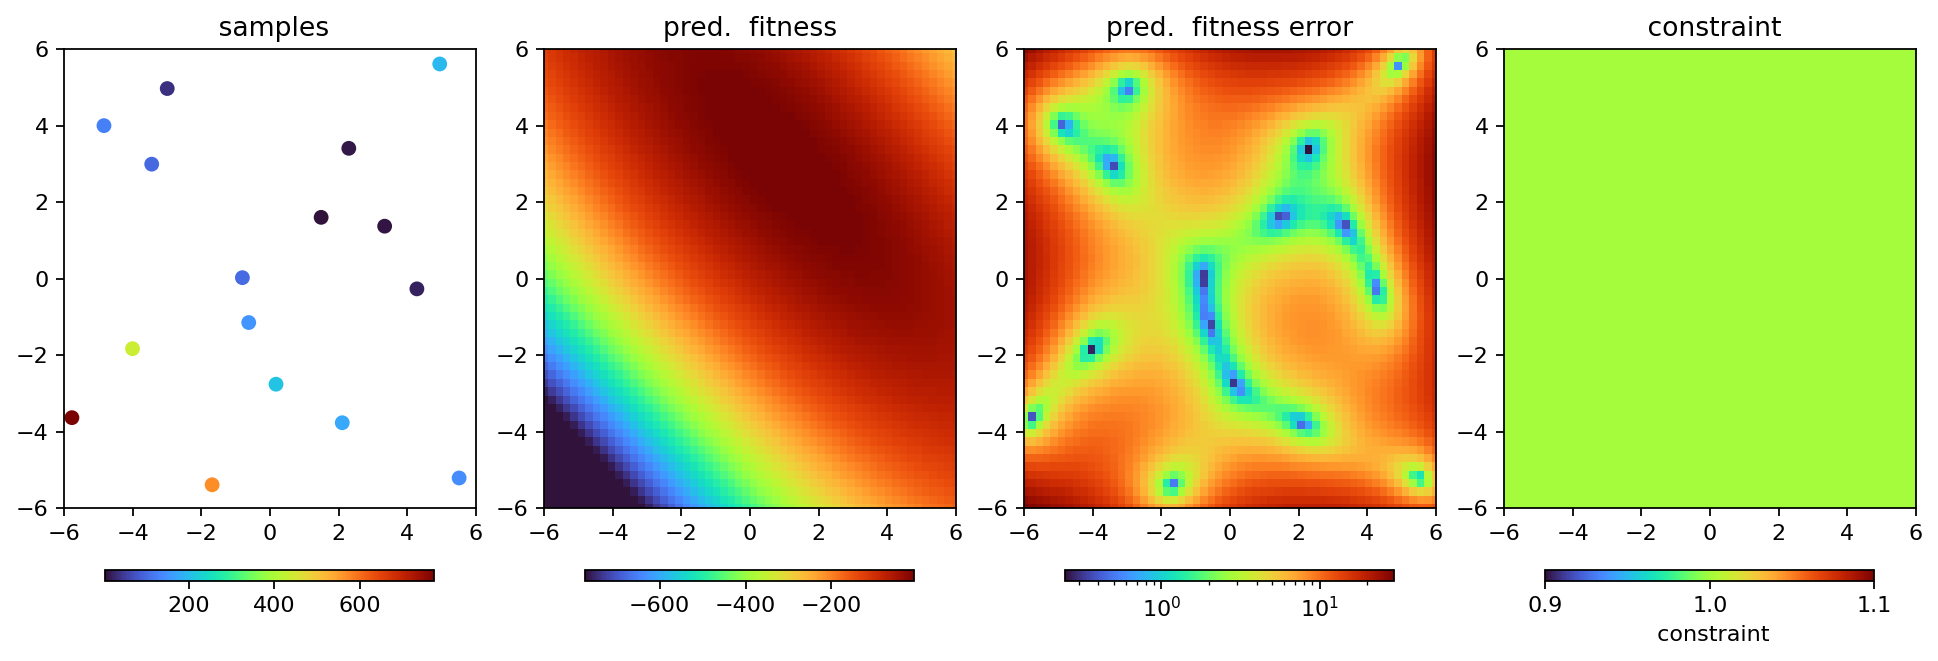

In [ ]:
from blop import DOF, Agent, Objective

dofs = [
    DOF(name="x1", search_domain=(-6, 6)),
    DOF(name="x2", search_domain=(-6, 6)),
]

objectives = [
    Objective(name="booth", target="min"),
]


agent = Agent(
    dofs=dofs,
    objectives=objectives,
    digestion=digestion,
    tiled=tiled,
)

RE(agent.learn(acqf="qr", n=16))

agent.plot_objectives()

In addition to modeling the fitness of the task, the agent models the probability that an input will be feasible:

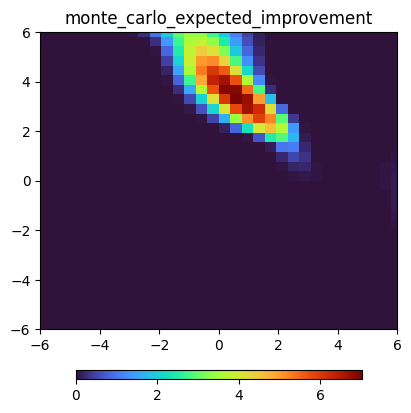

In [ ]:
agent.plot_acquisition(acqf="qei")

2025-04-02 09:41:29.604 INFO: Executing plan <generator object Agent.learn at 0x7244bab7af20>
2025-04-02 09:41:29.605 INFO: Change state on <bluesky.run_engine.RunEngine object at 0x7244da102fd0> from 'idle' -> 'running'
2025-04-02 09:41:30.461 INFO: HTTP Request: POST http://127.0.0.1:44975/api/v1/metadata/ "HTTP/1.1 200 OK"
2025-04-02 09:41:30.469 INFO: HTTP Request: GET http://127.0.0.1:44975/api/v1/search//09435a1a-06fa-486d-9361-87dd2220c572?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-04-02 09:41:30.477 INFO: HTTP Request: POST http://127.0.0.1:44975/api/v1/metadata//09435a1a-06fa-486d-9361-87dd2220c572 "HTTP/1.1 200 OK"
2025-04-02 09:41:30.486 INFO: HTTP Request: POST http://127.0.0.1:44975/api/v1/metadata//09435a1a-06fa-486d-9361-87dd2220c572/primary "HTTP/1.1 200 OK"
2025-04-02 09:41:30.494 INFO: HTTP Request: POST http://127.0.0.1:44975/api/v1/metadata//09435a1a-06fa-486d-9361-87dd2220c572/primary "HTTP/1.1 200 OK"
2025-04-02 09:41:30.501 INFO: HTTP Request: POST h



Transient Scan ID: 2     Time: 2025-04-02 09:41:30
Persistent Unique Scan ID: '09435a1a-06fa-486d-9361-87dd2220c572'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         x1 |         x2 |
+-----------+------------+------------+------------+
|         1 | 09:41:30.5 |     -0.782 |      6.000 |
|         2 | 09:41:30.6 |     -0.124 |      4.352 |
|         3 | 09:41:30.6 |      0.542 |      3.473 |


2025-04-02 09:41:30.654 INFO: HTTP Request: GET http://127.0.0.1:44975/api/v1/metadata/09435a1a-06fa-486d-9361-87dd2220c572/primary/internal/events "HTTP/1.1 200 OK"
2025-04-02 09:41:30.661 INFO: HTTP Request: PATCH http://127.0.0.1:44975/api/v1/table/partition/09435a1a-06fa-486d-9361-87dd2220c572/primary/internal/events?partition=0 "HTTP/1.1 200 OK"
2025-04-02 09:41:30.667 INFO: HTTP Request: GET http://127.0.0.1:44975/api/v1/metadata//09435a1a-06fa-486d-9361-87dd2220c572/primary/internal "HTTP/1.1 200 OK"
2025-04-02 09:41:30.674 INFO: HTTP Request: GET http://127.0.0.1:44975/api/v1/search/09435a1a-06fa-486d-9361-87dd2220c572/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-04-02 09:41:30.679 INFO: HTTP Request: GET http://127.0.0.1:44975/api/v1/metadata/09435a1a-06fa-486d-9361-87dd2220c572/primary/internal/events "HTTP/1.1 200 OK"
2025-04-02 09:41:30.686 INFO: HTTP Request: PATCH http://127.0.0.1:44975/api/v1/table/partition/09435a1a-06fa-486d-9361-87dd2220c57

|         4 | 09:41:30.6 |      1.643 |      2.445 |
+-----------+------------+------------+------------+
generator list_scan ['09435a1a'] (scan num: 2)





2025-04-02 09:41:31.877 INFO: HTTP Request: POST http://127.0.0.1:44975/api/v1/metadata/ "HTTP/1.1 200 OK"
2025-04-02 09:41:31.885 INFO: HTTP Request: GET http://127.0.0.1:44975/api/v1/search//6494c0be-b833-48de-b051-626583b747d5?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-04-02 09:41:31.892 INFO: HTTP Request: POST http://127.0.0.1:44975/api/v1/metadata//6494c0be-b833-48de-b051-626583b747d5 "HTTP/1.1 200 OK"
2025-04-02 09:41:31.899 INFO: HTTP Request: POST http://127.0.0.1:44975/api/v1/metadata//6494c0be-b833-48de-b051-626583b747d5/primary "HTTP/1.1 200 OK"
2025-04-02 09:41:31.906 INFO: HTTP Request: POST http://127.0.0.1:44975/api/v1/metadata//6494c0be-b833-48de-b051-626583b747d5/primary "HTTP/1.1 200 OK"
2025-04-02 09:41:31.913 INFO: HTTP Request: POST http://127.0.0.1:44975/api/v1/metadata//6494c0be-b833-48de-b051-626583b747d5/primary "HTTP/1.1 200 OK"
2025-04-02 09:41:31.920 INFO: HTTP Request: PATCH http://127.0.0.1:44975/api/v1/metadata//6494c0be-b833-48de-b051-62658



Transient Scan ID: 3     Time: 2025-04-02 09:41:31
Persistent Unique Scan ID: '6494c0be-b833-48de-b051-626583b747d5'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         x1 |         x2 |
+-----------+------------+------------+------------+
|         1 | 09:41:31.9 |      0.910 |      2.946 |
|         2 | 09:41:32.0 |      1.025 |      3.016 |
|         3 | 09:41:32.0 |      0.933 |      3.274 |


2025-04-02 09:41:32.069 INFO: HTTP Request: PATCH http://127.0.0.1:44975/api/v1/table/partition/6494c0be-b833-48de-b051-626583b747d5/primary/internal/events?partition=0 "HTTP/1.1 200 OK"
2025-04-02 09:41:32.075 INFO: HTTP Request: GET http://127.0.0.1:44975/api/v1/metadata//6494c0be-b833-48de-b051-626583b747d5/primary/internal "HTTP/1.1 200 OK"
2025-04-02 09:41:32.080 INFO: HTTP Request: GET http://127.0.0.1:44975/api/v1/search/6494c0be-b833-48de-b051-626583b747d5/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-04-02 09:41:32.085 INFO: HTTP Request: GET http://127.0.0.1:44975/api/v1/metadata/6494c0be-b833-48de-b051-626583b747d5/primary/internal/events "HTTP/1.1 200 OK"
2025-04-02 09:41:32.092 INFO: HTTP Request: PATCH http://127.0.0.1:44975/api/v1/table/partition/6494c0be-b833-48de-b051-626583b747d5/primary/internal/events?partition=0 "HTTP/1.1 200 OK"
2025-04-02 09:41:32.202 INFO: HTTP Request: PATCH http://127.0.0.1:44975/api/v1/metadata//6494c0be-b833-48de-b

|         4 | 09:41:32.0 |      0.724 |      3.261 |
+-----------+------------+------------+------------+
generator list_scan ['6494c0be'] (scan num: 3)





2025-04-02 09:41:32.765 INFO: HTTP Request: POST http://127.0.0.1:44975/api/v1/metadata/ "HTTP/1.1 200 OK"
2025-04-02 09:41:32.772 INFO: HTTP Request: GET http://127.0.0.1:44975/api/v1/search//1ed331d8-6993-42b6-9693-e8972737426f?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-04-02 09:41:32.779 INFO: HTTP Request: POST http://127.0.0.1:44975/api/v1/metadata//1ed331d8-6993-42b6-9693-e8972737426f "HTTP/1.1 200 OK"




Transient Scan ID: 4     Time: 2025-04-02 09:41:32
Persistent Unique Scan ID: '1ed331d8-6993-42b6-9693-e8972737426f'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         x1 |         x2 |
+-----------+------------+------------+------------+


2025-04-02 09:41:33.013 INFO: HTTP Request: POST http://127.0.0.1:44975/api/v1/metadata//1ed331d8-6993-42b6-9693-e8972737426f/primary "HTTP/1.1 200 OK"
2025-04-02 09:41:33.021 INFO: HTTP Request: POST http://127.0.0.1:44975/api/v1/metadata//1ed331d8-6993-42b6-9693-e8972737426f/primary "HTTP/1.1 200 OK"
2025-04-02 09:41:33.027 INFO: HTTP Request: POST http://127.0.0.1:44975/api/v1/metadata//1ed331d8-6993-42b6-9693-e8972737426f/primary "HTTP/1.1 200 OK"
2025-04-02 09:41:33.034 INFO: HTTP Request: PATCH http://127.0.0.1:44975/api/v1/metadata//1ed331d8-6993-42b6-9693-e8972737426f/primary "HTTP/1.1 200 OK"
2025-04-02 09:41:33.040 INFO: HTTP Request: GET http://127.0.0.1:44975/api/v1/metadata//1ed331d8-6993-42b6-9693-e8972737426f/primary/config "HTTP/1.1 200 OK"
2025-04-02 09:41:33.046 INFO: HTTP Request: GET http://127.0.0.1:44975/api/v1/search/1ed331d8-6993-42b6-9693-e8972737426f/primary/config?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-04-02 09:41:33.057 INFO: HTTP Request: P

|         1 | 09:41:33.1 |      0.895 |      3.074 |
|         2 | 09:41:33.1 |      1.052 |      3.058 |
|         3 | 09:41:33.1 |      1.057 |      2.959 |
|         4 | 09:41:33.1 |      1.163 |      2.831 |


2025-04-02 09:41:33.322 INFO: HTTP Request: PATCH http://127.0.0.1:44975/api/v1/metadata//1ed331d8-6993-42b6-9693-e8972737426f "HTTP/1.1 200 OK"
2025-04-02 09:41:33.328 INFO: HTTP Request: GET http://127.0.0.1:44975/api/v1/metadata/1ed331d8-6993-42b6-9693-e8972737426f "HTTP/1.1 200 OK"
2025-04-02 09:41:33.335 INFO: HTTP Request: GET http://127.0.0.1:44975/api/v1/metadata/1ed331d8-6993-42b6-9693-e8972737426f/primary/internal/events "HTTP/1.1 200 OK"


+-----------+------------+------------+------------+
generator list_scan ['1ed331d8'] (scan num: 4)





2025-04-02 09:41:33.765 INFO: HTTP Request: POST http://127.0.0.1:44975/api/v1/metadata/ "HTTP/1.1 200 OK"
2025-04-02 09:41:33.773 INFO: HTTP Request: GET http://127.0.0.1:44975/api/v1/search//92b8690a-b5dd-4031-8b3d-7942730dbe61?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-04-02 09:41:33.780 INFO: HTTP Request: POST http://127.0.0.1:44975/api/v1/metadata//92b8690a-b5dd-4031-8b3d-7942730dbe61 "HTTP/1.1 200 OK"
2025-04-02 09:41:33.788 INFO: HTTP Request: POST http://127.0.0.1:44975/api/v1/metadata//92b8690a-b5dd-4031-8b3d-7942730dbe61/primary "HTTP/1.1 200 OK"
2025-04-02 09:41:33.795 INFO: HTTP Request: POST http://127.0.0.1:44975/api/v1/metadata//92b8690a-b5dd-4031-8b3d-7942730dbe61/primary "HTTP/1.1 200 OK"
2025-04-02 09:41:33.802 INFO: HTTP Request: POST http://127.0.0.1:44975/api/v1/metadata//92b8690a-b5dd-4031-8b3d-7942730dbe61/primary "HTTP/1.1 200 OK"
2025-04-02 09:41:33.809 INFO: HTTP Request: PATCH http://127.0.0.1:44975/api/v1/metadata//92b8690a-b5dd-4031-8b3d-79427



Transient Scan ID: 5     Time: 2025-04-02 09:41:33
Persistent Unique Scan ID: '92b8690a-b5dd-4031-8b3d-7942730dbe61'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         x1 |         x2 |
+-----------+------------+------------+------------+
|         1 | 09:41:33.8 |      1.150 |      2.867 |
|         2 | 09:41:33.9 |      1.023 |      2.987 |
|         3 | 09:41:33.9 |      0.995 |      3.098 |


2025-04-02 09:41:33.959 INFO: HTTP Request: PATCH http://127.0.0.1:44975/api/v1/table/partition/92b8690a-b5dd-4031-8b3d-7942730dbe61/primary/internal/events?partition=0 "HTTP/1.1 200 OK"
2025-04-02 09:41:33.965 INFO: HTTP Request: GET http://127.0.0.1:44975/api/v1/metadata//92b8690a-b5dd-4031-8b3d-7942730dbe61/primary/internal "HTTP/1.1 200 OK"
2025-04-02 09:41:33.970 INFO: HTTP Request: GET http://127.0.0.1:44975/api/v1/search/92b8690a-b5dd-4031-8b3d-7942730dbe61/primary/internal?page%5Boffset%5D=0&fields=&sort= "HTTP/1.1 200 OK"
2025-04-02 09:41:33.975 INFO: HTTP Request: GET http://127.0.0.1:44975/api/v1/metadata/92b8690a-b5dd-4031-8b3d-7942730dbe61/primary/internal/events "HTTP/1.1 200 OK"
2025-04-02 09:41:33.982 INFO: HTTP Request: PATCH http://127.0.0.1:44975/api/v1/table/partition/92b8690a-b5dd-4031-8b3d-7942730dbe61/primary/internal/events?partition=0 "HTTP/1.1 200 OK"
2025-04-02 09:41:34.093 INFO: HTTP Request: PATCH http://127.0.0.1:44975/api/v1/metadata//92b8690a-b5dd-4031-8

|         4 | 09:41:33.9 |      0.872 |      3.073 |
+-----------+------------+------------+------------+
generator list_scan ['92b8690a'] (scan num: 5)





2025-04-02 09:41:34.167 INFO: Change state on <bluesky.run_engine.RunEngine object at 0x7244da102fd0> from 'running' -> 'idle'
2025-04-02 09:41:34.167 INFO: Cleaned up from plan <generator object Agent.learn at 0x7244bab7af20>


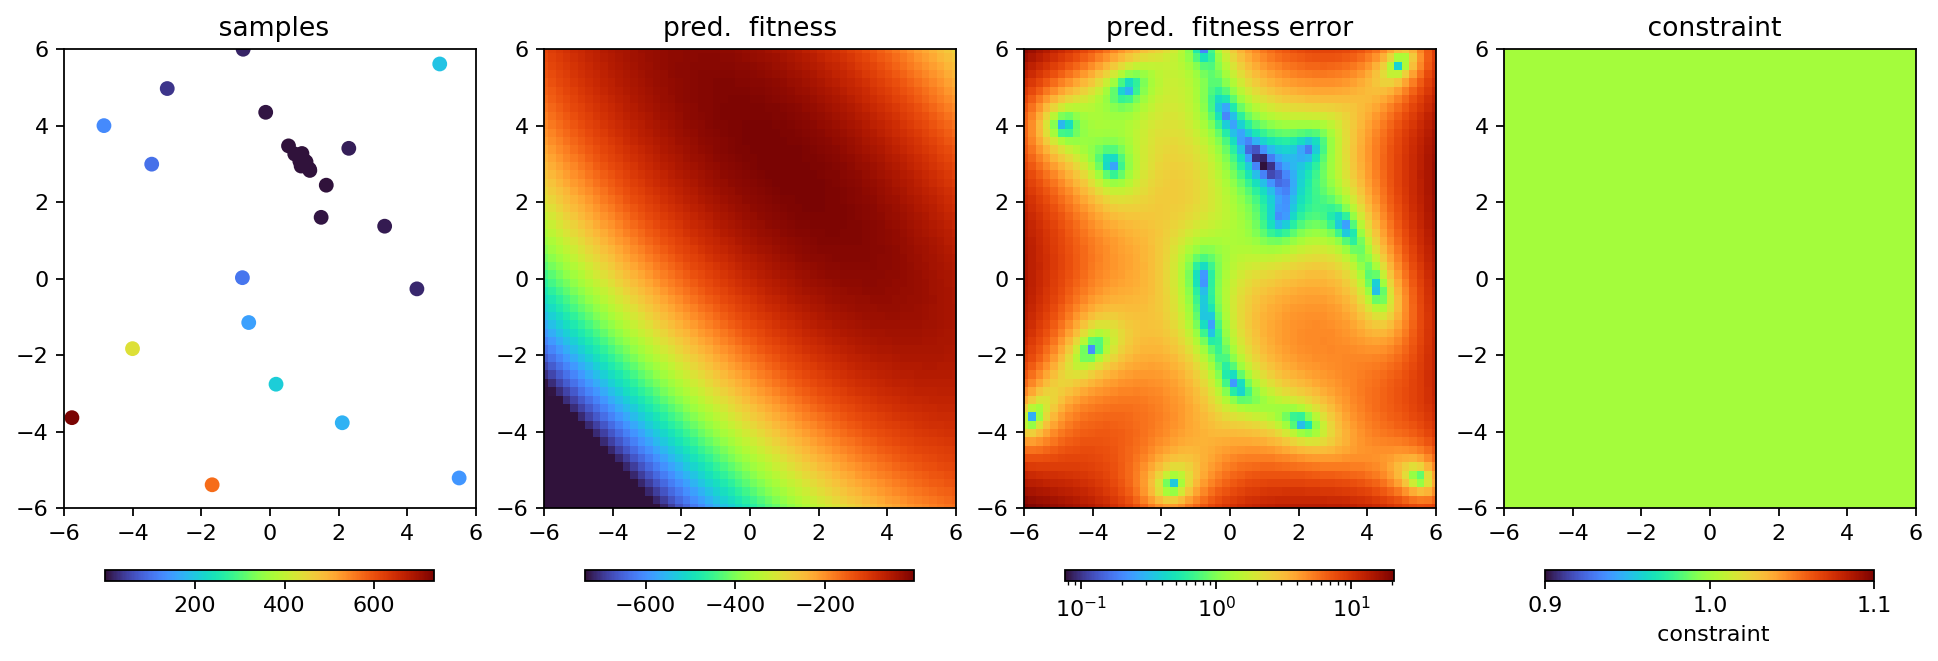

In [ ]:
RE(agent.learn("qei", n=4, iterations=4))
agent.plot_objectives()

In [ ]:
agent.best

x1                                 1.023284
x2                                 2.987071
booth                              0.001138
seq_num                                   2
ts_x1                     1743601293.909108
ts_x2                     1743601293.909317
acqf       monte_carlo_expected_improvement
Name: 29, dtype: object

In [8]:
tiled_server.close()

In [ ]:
tiled_server.close()